In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_csv('phishing_email.csv')
df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [3]:
# Basic statistics
print("Number of records:", len(df))
print("Distribution of labels:", df['label'].value_counts())

Number of records: 82486
Distribution of labels: 1    42891
0    39595
Name: label, dtype: int64


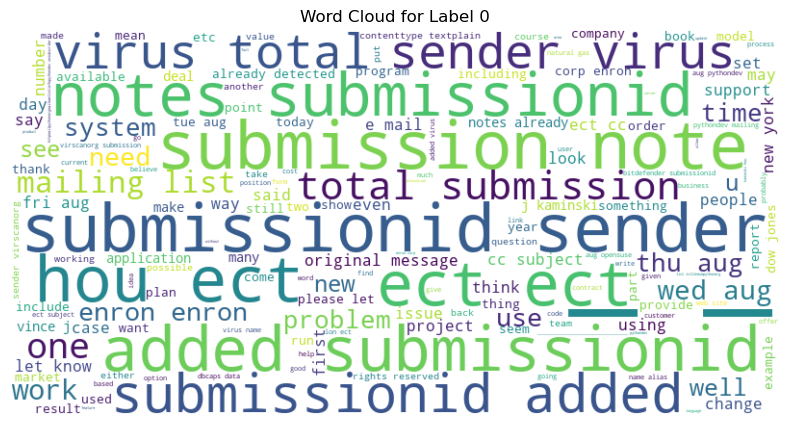

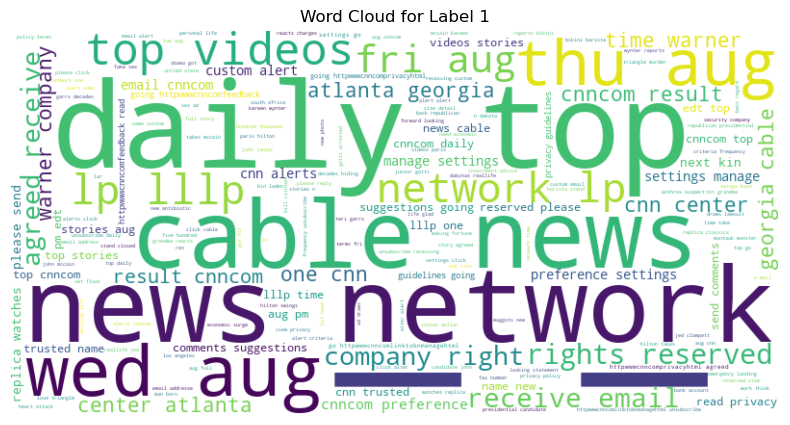

In [4]:
# Word cloud for each label
for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['text_combined'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label {label}')
    plt.show()

In [5]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [6]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(df['text_combined'])
X = tokenizer.texts_to_sequences(df['text_combined'])

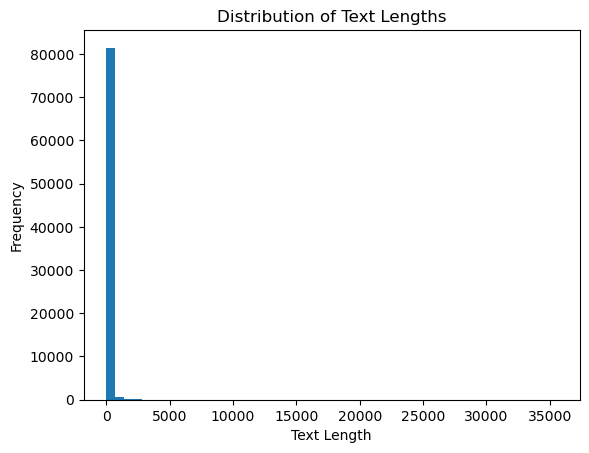

In [7]:
# Analyze the distribution of text lengths
text_lengths = [len(seq) for seq in X]
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [8]:
# Calculate the 95th percentile length
maxlen = int(np.percentile(text_lengths, 95))
print(f'Suggested maxlen: {maxlen}')

Suggested maxlen: 344


In [9]:
# Pad sequences
X = pad_sequences(X, maxlen=maxlen)

In [10]:
# Prepare labels
y = df['label'].values

In [11]:
# Set aside 10% of the data for final evaluation
X_train_full, X_final_test, y_train_full, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [13]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 344, 128)          640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 344, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 731,701
Trainable params: 731,701
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
928/928 [==============================] - 608s 655ms/step - loss: 0.0990 - accuracy: 0.9631 - val_loss: 0.0540 - val_accuracy: 0.9822
Epoch 2/10
928/928 [==============================] - 621s 669ms/step - loss: 0.0411 - accuracy: 0.9874 - val_loss: 0.0572 - val_accuracy: 0.9829
Epoch 3/10
928/928 [==============================] - 638s 688ms/step - loss: 0.0271 - accuracy: 0.9911 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 4/10
928/928 [==============================] - 641s 691ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0508 - val_accuracy: 0.9853
Epoch 5/10
928/928 [==============================] - 640s 689ms/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 0.0550 - val_accuracy: 0.9853
Epoch 6/10
928/928 [==============================] - 646s 696ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0485 - val_accuracy: 0.9859
Epoch 7/10
928/928 [==============================] - 645s 695ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0549 -

In [15]:
# Evaluate the model on the final held-out test set
loss, accuracy = model.evaluate(X_final_test, y_final_test)
print(f'Final Test Accuracy: {accuracy:.4f}')

258/258 [==============================] - 5s 21ms/step - loss: 0.0551 - accuracy: 0.9846
Final Test Accuracy: 0.9846


In [16]:
# Generate accuracy metrics for the training and validation data
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
y_final_test_pred = (model.predict(X_final_test) > 0.5).astype("int32")

In [17]:
print("Training Data Evaluation:")
print(f'Accuracy: {accuracy_score(y_train, y_train_pred):.4f}')
print(classification_report(y_train, y_train_pred))

Training Data Evaluation:
Accuracy: 0.9988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28446
           1       1.00      1.00      1.00     30943

    accuracy                           1.00     59389
   macro avg       1.00      1.00      1.00     59389
weighted avg       1.00      1.00      1.00     59389



In [18]:
print("Validation Data Evaluation:")
print(f'Accuracy: {accuracy_score(y_val, y_val_pred):.4f}')
print(classification_report(y_val, y_val_pred))

Validation Data Evaluation:
Accuracy: 0.9859
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7203
           1       0.98      0.99      0.99      7645

    accuracy                           0.99     14848
   macro avg       0.99      0.99      0.99     14848
weighted avg       0.99      0.99      0.99     14848



In [19]:
print("Final Test Data Evaluation:")
print(f'Accuracy: {accuracy_score(y_final_test, y_final_test_pred):.4f}')
print(classification_report(y_final_test, y_final_test_pred))

Final Test Data Evaluation:
Accuracy: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3946
           1       0.98      0.99      0.99      4303

    accuracy                           0.98      8249
   macro avg       0.98      0.98      0.98      8249
weighted avg       0.98      0.98      0.98      8249

